In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import process_data.dire_and_coor as dc
import functions as func
import process_data.n_n_distance as nn
import json

## Nov 5
### random polymer for 4 layers

In [2]:
def check_output_hist(gen, number_bin, z_dim, num_polymer, epoch):

    noise = func.get_noise(num_polymer, z_dim)
    output = gen(noise).data.numpy()
    output = output.reshape(-1,1)

    plt.hist(output, density=True, bins=number_bin)
    plt.title(f'output of generator{epoch}')
    plt.show()

    output = np.round(output)
    sns.histplot(output)
    plt.title('output of generator after round')
    plt.show()


def round_and_reshape(model, num_polymer, z_dim, shifted=True):
    # load model
    # get output
    noise = func.get_noise(num_polymer, z_dim)
    output = model(noise).data.numpy()
    # round and reshape output
    output = np.round(output * 4) / 4
    if shifted:
        output += (0.75/2)
    for i in range(len(output)):
        for j in range(len(output[i])):
            if output[i][j] == 1.:
                output[i][j] = 0
    directions_14 = output.reshape((num_polymer, 14, 1))
    directions = np.zeros((num_polymer, 15, 1))
    for i in range(len(directions)):
        directions[i] = np.vstack(([0], directions_14[i]))
    return directions

def directions_to_str(directions):
    st_all = []
    for direction in directions:
        st = ""
        for i in direction:
            st += str(int(i[0] * 4))
        st_all.append(st)
    return st_all

## conclusion we can draw for now
1. the single node won't work for GAN, single node means no hidden layers, no matter how many

<AxesSubplot:ylabel='Count'>

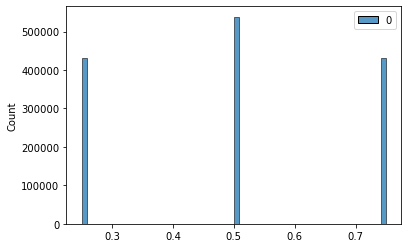

In [9]:
input_sin_cos = np.load('../data/self_avoid/16/directions.npy')
input_coordinates = np.load('../data/self_avoid/16/coorinates.npy')
input_hist = input_sin_cos.reshape(-1, 1)
sns.histplot(input_hist)

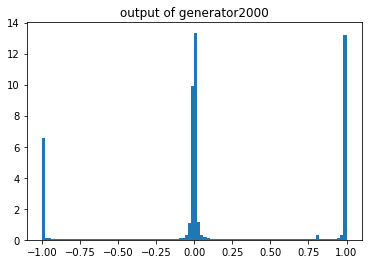

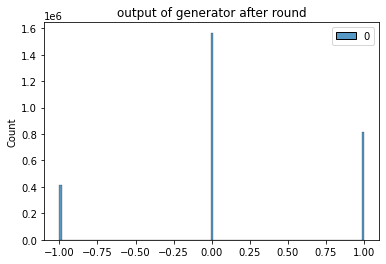

In [5]:
import fnn.four_layers as four_layers
generator = four_layers.GeneratorNet(14, 28)
# for i in range(1, 19):
# check_point = torch.load(f'../experiments/11_5/four_layers_sin_cos_gen_{2000}.pth.tar')
check_point = torch.load(f'../experiments/11_7/four_layers_sincos_gen_{2000}.pth.tar')
generator.load_state_dict(check_point['gen_state_dict'])
check_output_hist(generator, 100, 14, 100000, 2000)

In [6]:
num_polymer = 10000
z_dim = 14
noise = func.get_noise(num_polymer, z_dim)
output = generator(noise).data.numpy()

output = output.reshape(num_polymer, 14, 2)
# convert sin cos coordinates to turn directions
directions = np.zeros([num_polymer, 14, 1])
convert = {
    "backward": 0,
    "right_turn": 1/4,
    "forward": 1 / 2,
    "left_turn": 3 / 4
}

for index, direction in enumerate(directions):
# test = np.zeros((14, 1))
#     j = 0
    for j, item in enumerate(output[index]):
        if item[np.argmax(np.abs(item))] < 0:
            if np.argmax(np.abs(item)) == 0:
                # the result is [-1,0]
                direction[j] = convert['backward']
            else:
                # result is [0,-1]
                direction[j] = convert['left_turn']
        elif item[np.argmax(np.abs(item))] > 0:
            if np.argmax(np.abs(item)) == 0:
                # the result is [1,0]
                direction[j] = convert['forward']
            else:
                # result is [0,1]
                direction[j] = convert['right_turn']

In [7]:
a = np.zeros((10000, 15, 1))
# make the first one is forward
for i in range(len(a)):
    a[i] = np.vstack(([0], directions[i]))
coordinates = dc.direction_coordinate_three(a, 16)

In [8]:
nndistance = nn.n_n_distance(coordinates)
print(nndistance)
ratio = nndistance / np.sqrt(15)
print(ratio)

5.99559838548247
1.5480568465014455


In [10]:
input_nn = nn.n_n_distance(input_coordinates)
print(input_nn)

6.8818137144215115


In [20]:
c = directions_to_str(directions)
list_2 = list(set(c))
num_independent_polymer = len(list_2)
print(num_independent_polymer)

9085


In [21]:
# load real polymer
real_direction = np.load('../data/random/16/directions.npy')
real_direction_str = directions_to_str(real_direction)

In [26]:
overlap_count = 0
for i in c:
    if i in real_direction_str:
        overlap_count += 1
print(overlap_count)

5


In [27]:
print(f'the overlap percentage is {overlap_count / 10000 * 100}%')

the overlap percentage is 0.05%


## Nov 7
### self avoid polymer for 4 layers
### z dimension is 14

In [12]:
#
def check_fold_cross(coordinate):
    """
    check if a single polymer is folding or crossing
    """
    assert np.shape(coordinate) == (16, 2)
    folding_count = 0
    crossing_count = 0
    for i in range(0, len(coordinate)):
        temp = coordinate[i]
        if (temp == coordinate[:i]).all(axis=1).any():
            if np.array_equal(temp, coordinate[:i][-2]):
                folding_count += 1
            else:
                crossing_count += 1
    return [folding_count, crossing_count]


In [14]:
check_list = []
for coordinate in coordinates:
    check_list.append(check_fold_cross(coordinate))



In [16]:
count = 1
for i in check_list:
    if i == [0,0]:
        count += 1




In [17]:
count/10000


0.4841